# Weather Image Recognition
Alex Costa (ID: 5308225) - Università Cattolica del Sacro Cuore




The goal of this project is to train a Convolutional Neural Network (CNN) from scratch to **classify weather conditions** based on images. The model will categorize each image into one of the following 11 weather classes:

1.   Dew
2.   Fog/Smog
3.   Frost
4.   Glaze
5.   Hail
6.   Lightning
7.   Rain
8.   Rainbow
9.   Rime
10.  Sandstorm
11.  Snow

The dataset consists of 6,862 images, with an imbalanced class distribution. The Rainbow class is the least represented, with 232 images, while Rime is the most frequent, with 1,160 images. The dataset was sourced from Kaggle and is available at the following link: https://www.kaggle.com/datasets/fceb22ab5e1d5288200c0f3016ccd626276983ca1fe8705ae2c32f7064d719de

The model that will be implemented could be useful for various real-world applications where weather classification from images can provide valuable insights. Here are some **practical use cases**:
*   it can be integrated into weather stations or satellite imaging systems to automatically classify weather conditions without human intervention
*   environmental agencies could use this model to detect and track extreme weather events like sandstorms, hail, or frost
*   insurance companies could use the model to validate weather-related claims (e.g., hail damage, storms) by analyzing images taken at the event location
*   apps or websites could integrate this model to provide real-time weather classification from user-uploaded images, helping travelers plan activities based on visual weather conditions

## 1. Data loading and exploration


In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import random
import shutil

import torch
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [ ]:
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Università/Deep Learning for AI/Project
#!unzip "archive.zip"

In [ ]:
# Paths
data_dir = "/content/drive/MyDrive/Università/Deep Learning for AI/Project/dataset"
checkpoint_dir = '/content/drive/MyDrive/Università/Deep Learning for AI/Project'

Before starting I set a **seed**. Setting the seed ensures:
*    The same train/validation/test split every time
*    The same initial weight initialization
*    The same random operations like data augmentation and dropout
*    Consistency across different training runs

In [ ]:
# Set a global seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

I load the dataset and randomly split it into **train** (80%), **validation** (10%) and **test** (10%) sets.

In [ ]:
# Load dataset
data = datasets.ImageFolder(root=data_dir)

# Split dataset into train, validation, and test
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    data, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed)
)

The CNN I will implement requires images of dimension 3 x 224 x 224 (3 channels RGB, 224 pixels x 224 pixels), hence when I create the dataloaders I resize the images. Furthermore, I apply some **data augmentation** only to the train set, expanding the diversity of the dataset without actually collecting new images, helping the model generalize better and perform well on unseen weather images. Specifically, I apply the following transformations:

*   Random Horizontal Flip: flips the image horizontally with a 50% probability
*   Random Rotation: randomly rotates the image by up to ±15 degrees
*   Random Affine: randomly shifts the image by up to 10% of its width and height
*   Color Jitter: randomly alters image colors (brightness, contrast, saturation, hue)


In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Apply different transformations using dataset wrappers
train_set.dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_set.dataset = datasets.ImageFolder(root=data_dir, transform=test_val_transform)
test_set.dataset = datasets.ImageFolder(root=data_dir, transform=test_val_transform)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
print("Sets dimensions:\n")
print(f"Train:      {len(train_loader.dataset)}\nValidation: {len(val_loader.dataset)}\nTest:       {len(test_loader.dataset)}")

Sets dimensions:

Train:      5489
Validation: 686
Test:       687


In [ ]:
# Get class indices from the training set
class_counts = Counter([data.targets[idx] for idx in train_set.indices])

# Map indices to class names
class_names = data.classes

# Print the count for each class
print("Number of images per class in the training set:")
for class_idx, count in sorted(class_counts.items()):
    print(f"{class_names[class_idx]}: {count}")

Number of images per class in the training set:
dew: 552
fogsmog: 680
frost: 375
glaze: 524
hail: 453
lightning: 296
rain: 422
rainbow: 187
rime: 949
sandstorm: 554
snow: 497


As I already mentioned, we have a moderate **unbalance** in the dataset. We can see above the number of images for each class in the train set: the most frequent class (rime) is 5 times larger than the least frquent one (rainbow). This could lead the model to predict the majority class more often and neglect the minority class. Data augmentation can help mitigate this issue because it creates variations of existing images, reducing overfitting and improving robustness. But most importantly, I will apply class **weights** to give more importance to minority classes during training.

In [ ]:
def visualize_images(dataloader, class_names=None, num_images=8):
    '''Visualizes a sample of images from the dataset'''

    # Fetch one batch of data
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Select only the required number of images
    images, labels = images[:num_images], labels[:num_images]

    # Set up grid for displaying images
    num_cols = min(num_images, 4)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    # Flatten axes to avoid indexing errors
    axes = np.array(axes).flatten()

    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0).cpu())  # No need for numpy()
        title = class_names[labels[i].item()] if class_names else f"{labels[i].item()}"
        axes[i].set_title(title)
        axes[i].axis("off")

    # Hide unused axes
    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

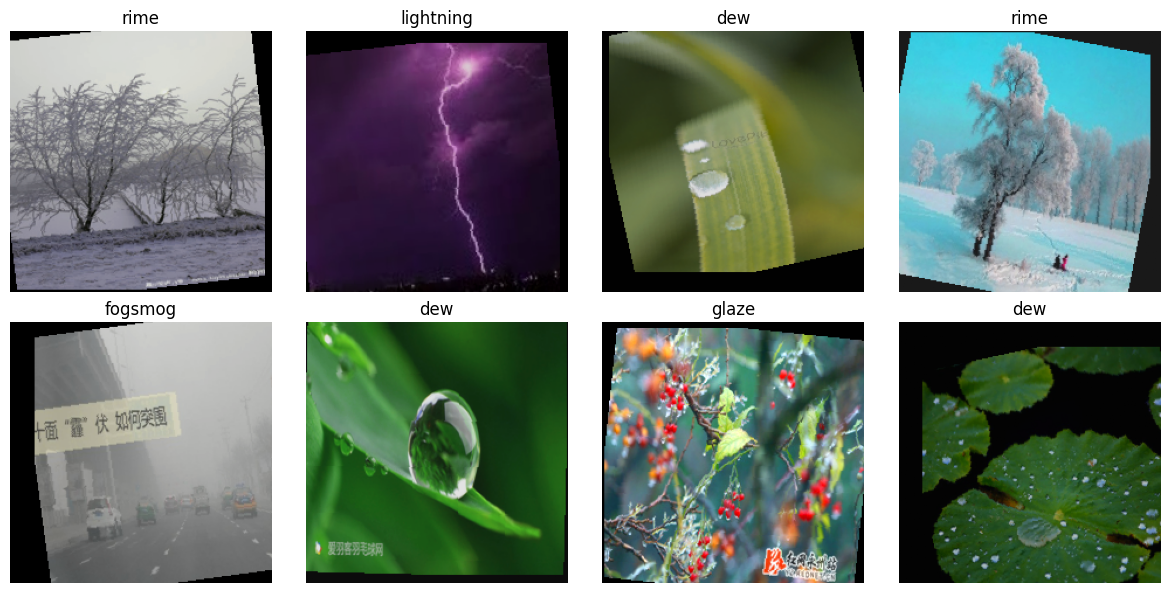

In [ ]:
# Call the function to visualize images
visualize_images(train_loader, class_names)

We can see above some images selected randomly from the train set, after applying the transformations explained before.

## 2. Convolutional Neural Network: GoogLeNet implementation

In this project, I chose to train a **GoogLeNet** model from scratch to classify weather conditions based on images. GoogLeNet, introduced by Szegedy et al. in 2014, was the winning architecture of the ILSVRC 2014 (ImageNet Large Scale Visual Recognition Challenge) and is well known for its efficiency, depth, and ability to extract hierarchical features.

Unlike traditional CNNs, GoogLeNet uses the **Inception module**, which allows the network to capture information at multiple scales by applying 1x1, 3x3, and 5x5 convolutions in parallel. This design reduces computational cost while maintaining high accuracy. Additionally, it includes auxiliary classifiers, which help combat the vanishing gradient problem by providing additional supervision during training.

Given the dataset’s relatively small size, training GoogLeNet from scratch allows complete control over feature extraction, without relying on pre-trained weights. This ensures the model learns to distinguish weather conditions directly from the dataset, rather than adapting to pre-existing features learned from unrelated images.

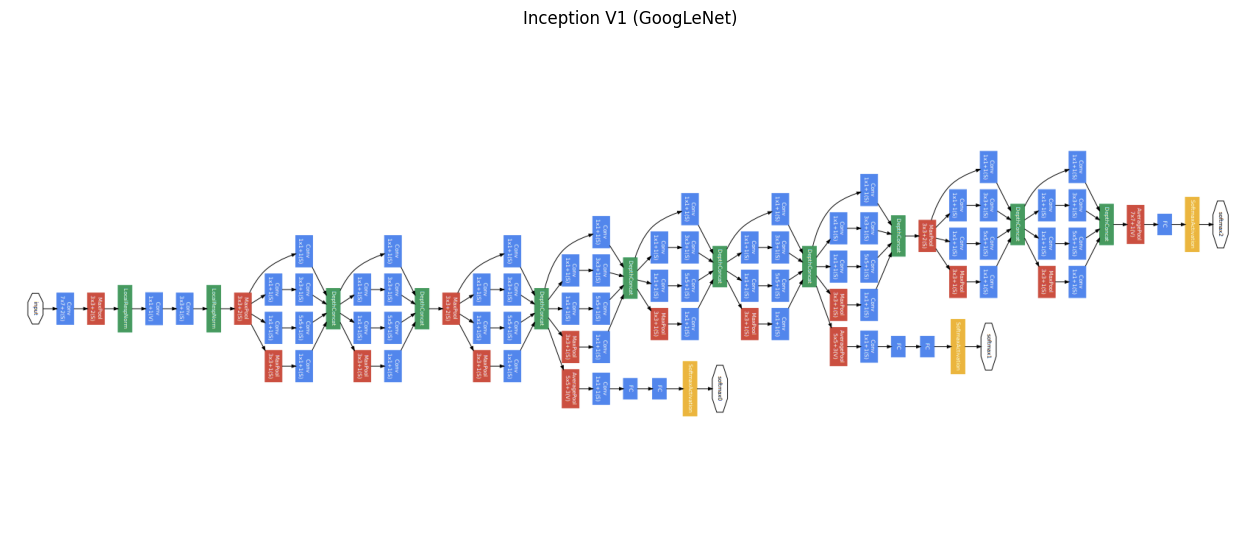

In [ ]:
# Visualize image of GoogLeNet
img_path = '/content/drive/MyDrive/Università/Deep Learning for AI/Project/Inception V1.png'
img = mpimg.imread(img_path)

rotated_img = np.rot90(img, k=3)

plt.figure(figsize=(16, 16))
plt.imshow(rotated_img)
plt.title("Inception V1 (GoogLeNet)")
plt.axis('off')
plt.show()

I implement GoogLeNet following the original Inception V1 architecture, with one key modification: replacing Local Response Normalization (LRN) with **Batch Normalization** (BN). While Batch Normalization was introduced in Inception V2, it has been shown to improve training stability and performance. In my implementation, Batch Normalization is applied after each convolution and before pooling, whereas Local Response Normalization in the original design was applied after pooling.

In [ ]:
class ConvBlock(nn.Module):
    '''Convolution block: convolution + batch normalization + relu'''

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [ ]:
class InceptionModule(nn.Module):
    '''Inception module with the 4 branches'''

    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pp):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=5, stride=1, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, f_pp, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [ ]:
class InceptionAux(nn.Module):
    '''Additional fifth branch for some of the inception modules'''

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.act(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

This is the explanation of the reason of the presence of the **auxiliary classifiers** in Szegedy et al.: "By adding auxiliary classifiers connected to these intermediate layers, we would expect to encourage discrimination in the lower stages in the classifier, increase the gradient signal that gets propagated back, and provide additional regularization. These classifiers take the form of smaller convolutional networks put on top of the output of the Inception (4a) and (4d) modules. During training, their loss gets added to the total loss of the network with a discount weight (the losses of the auxiliary classifiers were weighted by 0.3). At inference time, these auxiliary networks are discarded."

In [ ]:
class GoogLeNet(nn.Module):
    '''Complete GoogLeNet'''

    def __init__(self, num_classes=11):
        super(GoogLeNet, self).__init__()

        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception3A = InceptionModule(in_channels=192,
                                           f_1x1=64,
                                           f_3x3_r=96,
                                           f_3x3=128,
                                           f_5x5_r=16,
                                           f_5x5=32,
                                           f_pp=32)
        self.inception3B = InceptionModule(in_channels=256,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=192,
                                           f_5x5_r=32,
                                           f_5x5=96,
                                           f_pp=64)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception4A = InceptionModule(in_channels=480,
                                           f_1x1=192,
                                           f_3x3_r=96,
                                           f_3x3=208,
                                           f_5x5_r=16,
                                           f_5x5=48,
                                           f_pp=64)
        self.inception4B = InceptionModule(in_channels=512,
                                           f_1x1=160,
                                           f_3x3_r=112,
                                           f_3x3=224,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4C = InceptionModule(in_channels=512,
                                           f_1x1=128,
                                           f_3x3_r=128,
                                           f_3x3=256,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4D = InceptionModule(in_channels=512,
                                           f_1x1=112,
                                           f_3x3_r=144,
                                           f_3x3=288,
                                           f_5x5_r=32,
                                           f_5x5=64,
                                           f_pp=64)
        self.inception4E = InceptionModule(in_channels=528,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception5A = InceptionModule(in_channels=832,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.inception5B = InceptionModule(in_channels=832,
                                           f_1x1=384,
                                           f_3x3_r=192,
                                           f_3x3=384,
                                           f_5x5_r=48,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(1024, num_classes)

        self.aux4A = InceptionAux(512, num_classes)
        self.aux4D = InceptionAux(528, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.inception3A(x)
        x = self.inception3B(x)
        x = self.pool4(x)
        x = self.inception4A(x)

        aux1 = self.aux4A(x) if self.training else None  # only during training

        x = self.inception4B(x)
        x = self.inception4C(x)
        x = self.inception4D(x)

        aux2 = self.aux4D(x) if self.training else None  # only during training

        x = self.inception4E(x)
        x = self.pool5(x)
        x = self.inception5A(x)
        x = self.inception5B(x)
        x = self.pool6(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.fc(x)


        if self.training:
            return x, aux1, aux2  # Return all three outputs during training
        else:
            return x  # Only return the final output during inference

In [ ]:
# Initialize the model
net = GoogLeNet()

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3. Training and tuning

In [ ]:
def init_weights(m):
    '''Kaiming Normal Initialization for the weights: better than the Xavier for deep NN with ReLu activations'''
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [ ]:
def plot_metrics(train_losses, train_accs, val_accs):
    """Plot the training and validation metrics after training"""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # First y-axis for accuracy
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o', linestyle='-', color='orange')
    ax1.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', marker='o', linestyle='-', color='green')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 1)

    # Second y-axis for loss
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='s', linestyle='--', color='red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Legends
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.85))
    plt.title('Training and Validation Metrics')
    plt.show()

In [ ]:
def compute_class_weights(train_set, device):
    """Compute class weights based on the training dataset"""
    class_labels = np.array(sorted(class_counts.keys()))
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=[data.targets[idx] for idx in train_set.indices])
    weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    return weights_tensor

In [ ]:
def train(net, train_iter, val_iter, num_epochs, lr, checkpoint_dir, device, class_weights, patience=5):
    """Train a model with Adam optimizer and early stopping on validation accuracy"""

    # Define loss function with computed class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # Checkpoint and optimizer setup
    start_epoch = 0
    best_val_acc = 0
    epochs_without_improvement = 0
    checkpoint_path = os.path.join(checkpoint_dir, 'final_checkpoint.pth')
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net.to(device)
    print('Training on', device)

    # Store metrics for plotting
    train_losses, train_accs, val_accs = [], [], []

    for epoch in range(start_epoch, num_epochs):
        net.train()
        total_loss, correct, total = 0.0, 0, 0

        with tqdm(total=len(train_iter), desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for X, y in train_iter:
                optimizer.zero_grad()
                X, y = X.to(device), y.to(device)

                # Forward pass
                outputs = net(X)

                # Handle auxiliary outputs if present
                if isinstance(outputs, tuple):
                    outputs, aux1, aux2 = outputs
                    main_loss = loss_fn(outputs, y)
                    aux_loss1 = loss_fn(aux1, y)
                    aux_loss2 = loss_fn(aux2, y)
                    total_loss_batch = main_loss + 0.3 * (aux_loss1 + aux_loss2)
                else:
                    total_loss_batch = loss_fn(outputs, y)

                total_loss_batch.backward()
                optimizer.step()

                # Compute loss & accuracy
                total_loss += total_loss_batch.item() * X.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

                # Update progress bar
                train_loss = total_loss / total
                train_acc = correct / total
                pbar.set_postfix(loss=f'{train_loss:.4f}', accuracy=f'{train_acc:.4f}')
                pbar.update(1)

        # Store epoch metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation accuracy
        net.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for X, y in val_iter:
                X, y = X.to(device), y.to(device)
                outputs = net(X)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total
        val_accs.append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            print(f"New best validation accuracy: {val_acc:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation accuracy for {epochs_without_improvement} epoch(s).")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Save final checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
        'val_acc': best_val_acc
    }, checkpoint_path)
    print(f"Final checkpoint saved at {checkpoint_path}.")

    # Plot metrics after training
    plot_metrics(train_losses, train_accs, val_accs)

Before training my GoogLeNet, here is a summary of the hyperparameters that I chose:

*   Dataset split: 80% Train, 10% Validation, 10% Test
*   Data loaders: batch size = 64 and workers = 2
*   Inizialization: kaiming normal for weights and biases = 0
*   Max Epochs = 50
*   Optimization method: ADAM with Learning Rate = 0.0001, weight decay = 0
*   Early stopping: patience of 5 epochs on validation accuracy
*   Loss class weights: yes
*   Auxiliary losses weight = 0.3
*   Dropout = 0.3


Training on cuda


Epoch 1/50: 100%|██████████| 86/86 [02:12<00:00,  1.54s/it, accuracy=0.4864, loss=2.6382]


New best validation accuracy: 0.5831


Epoch 2/50: 100%|██████████| 86/86 [01:18<00:00,  1.09it/s, accuracy=0.6191, loss=1.9177]


New best validation accuracy: 0.6327


Epoch 3/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.6608, loss=1.6635]


New best validation accuracy: 0.6516


Epoch 4/50: 100%|██████████| 86/86 [01:18<00:00,  1.09it/s, accuracy=0.6881, loss=1.5305]


New best validation accuracy: 0.7289


Epoch 5/50: 100%|██████████| 86/86 [01:18<00:00,  1.09it/s, accuracy=0.7140, loss=1.3845]


No improvement in validation accuracy for 1 epoch(s).


Epoch 6/50: 100%|██████████| 86/86 [01:19<00:00,  1.08it/s, accuracy=0.7280, loss=1.3087]


No improvement in validation accuracy for 2 epoch(s).


Epoch 7/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.7559, loss=1.1886]


No improvement in validation accuracy for 3 epoch(s).


Epoch 8/50: 100%|██████████| 86/86 [01:17<00:00,  1.10it/s, accuracy=0.7495, loss=1.1768]


New best validation accuracy: 0.7522


Epoch 9/50: 100%|██████████| 86/86 [01:19<00:00,  1.09it/s, accuracy=0.7739, loss=1.0904]


No improvement in validation accuracy for 1 epoch(s).


Epoch 10/50: 100%|██████████| 86/86 [01:23<00:00,  1.03it/s, accuracy=0.7807, loss=1.0167]


No improvement in validation accuracy for 2 epoch(s).


Epoch 11/50: 100%|██████████| 86/86 [01:19<00:00,  1.09it/s, accuracy=0.7859, loss=1.0104]


No improvement in validation accuracy for 3 epoch(s).


Epoch 12/50: 100%|██████████| 86/86 [01:18<00:00,  1.09it/s, accuracy=0.7983, loss=0.9481]


New best validation accuracy: 0.7930


Epoch 13/50: 100%|██████████| 86/86 [01:20<00:00,  1.07it/s, accuracy=0.8165, loss=0.8640]


No improvement in validation accuracy for 1 epoch(s).


Epoch 14/50: 100%|██████████| 86/86 [01:19<00:00,  1.08it/s, accuracy=0.8089, loss=0.8946]


No improvement in validation accuracy for 2 epoch(s).


Epoch 15/50: 100%|██████████| 86/86 [01:19<00:00,  1.08it/s, accuracy=0.8207, loss=0.8269]


No improvement in validation accuracy for 3 epoch(s).


Epoch 16/50: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s, accuracy=0.8247, loss=0.8127]


No improvement in validation accuracy for 4 epoch(s).


Epoch 17/50: 100%|██████████| 86/86 [01:16<00:00,  1.12it/s, accuracy=0.8298, loss=0.7786]


New best validation accuracy: 0.8076


Epoch 18/50: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s, accuracy=0.8453, loss=0.7342]


No improvement in validation accuracy for 1 epoch(s).


Epoch 19/50: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s, accuracy=0.8390, loss=0.7474]


No improvement in validation accuracy for 2 epoch(s).


Epoch 20/50: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s, accuracy=0.8532, loss=0.6633]


New best validation accuracy: 0.8105


Epoch 21/50: 100%|██████████| 86/86 [01:16<00:00,  1.13it/s, accuracy=0.8583, loss=0.6596]


No improvement in validation accuracy for 1 epoch(s).


Epoch 22/50: 100%|██████████| 86/86 [01:16<00:00,  1.12it/s, accuracy=0.8515, loss=0.6621]


No improvement in validation accuracy for 2 epoch(s).


Epoch 23/50: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s, accuracy=0.8717, loss=0.5963]


New best validation accuracy: 0.8120


Epoch 24/50: 100%|██████████| 86/86 [01:17<00:00,  1.11it/s, accuracy=0.8727, loss=0.6020]


No improvement in validation accuracy for 1 epoch(s).


Epoch 25/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.8736, loss=0.5678]


No improvement in validation accuracy for 2 epoch(s).


Epoch 26/50: 100%|██████████| 86/86 [01:19<00:00,  1.09it/s, accuracy=0.8834, loss=0.5394]


New best validation accuracy: 0.8251


Epoch 27/50: 100%|██████████| 86/86 [01:18<00:00,  1.09it/s, accuracy=0.8905, loss=0.5100]


No improvement in validation accuracy for 1 epoch(s).


Epoch 28/50: 100%|██████████| 86/86 [01:19<00:00,  1.08it/s, accuracy=0.8870, loss=0.5207]


No improvement in validation accuracy for 2 epoch(s).


Epoch 29/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.8905, loss=0.4993]


New best validation accuracy: 0.8353


Epoch 30/50: 100%|██████████| 86/86 [01:19<00:00,  1.09it/s, accuracy=0.8858, loss=0.5311]


No improvement in validation accuracy for 1 epoch(s).


Epoch 31/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.8943, loss=0.4859]


No improvement in validation accuracy for 2 epoch(s).


Epoch 32/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.9002, loss=0.4556]


No improvement in validation accuracy for 3 epoch(s).


Epoch 33/50: 100%|██████████| 86/86 [01:17<00:00,  1.10it/s, accuracy=0.9085, loss=0.4164]


No improvement in validation accuracy for 4 epoch(s).


Epoch 34/50: 100%|██████████| 86/86 [01:18<00:00,  1.10it/s, accuracy=0.9033, loss=0.4514]


No improvement in validation accuracy for 5 epoch(s).
Early stopping triggered.
Final checkpoint saved at /content/drive/MyDrive/Università/Deep Learning for AI/Project/final_checkpoint.pth.


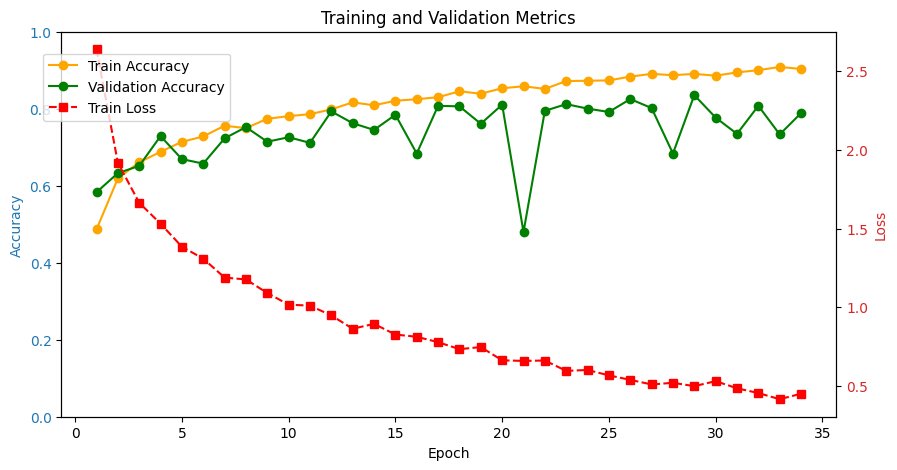

In [ ]:
class_weights = compute_class_weights(train_set, device)
train(net, train_loader, val_loader, 50, 0.0001, checkpoint_dir, device, class_weights, 5)

The training stopped after 34 epochs as the early stopping on the validation accuracy was triggered. Training accuracy steadily increases and reaches high values (>90%), indicating that the model is learning well on the training set. Validation accuracy improves initially but fluctuates in later epochs. At epoch 21, there is a noticeable drop, suggesting instability. In general, after epoch 20 the gap between training and validation accuracy seems to slowly increase, hence the early stopping succesfully prevented overfitting (maybe we could have stopped even before). Training loss continuously decreases as expected.

## 4. Testing

After training the GoogLeNet model, it is essential to evaluate its performance on **unseen data**. The testing phase is conducted using the test set, which consists of 10% of the original dataset and was never seen by the model during training or validation. To measure performance, the following metrics are considered:

*   Accuracy: the percentage of correctly classified images
*   Confusion Matrix: a detailed breakdown of correct and incorrect predictions per class
*   Precision, Recall, and F1-score: to analyze performance per class, particularly important given the dataset’s class imbalance.

In [ ]:
def load_trained_model(net, checkpoint_dir, device):
    """Load the trained model from the latest checkpoint for inference"""

    checkpoint_path = os.path.join(checkpoint_dir, 'final_checkpoint.pth')

    if os.path.exists(checkpoint_path):
        print(f"Loading trained model from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        net.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully.")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}.")

    net.to(device)
    net.eval()

    return net

In [ ]:
# Load the trained model
net = load_trained_model(net, checkpoint_dir, device)

Loading trained model from /content/drive/MyDrive/Università/Deep Learning for AI/Project/final_checkpoint.pth...
Model loaded successfully.


In [ ]:
def test_metrics(net, test_iter, device, plot_cm=False):
    '''Evaluate test accuracy and confusion matrix'''

    net.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print detailed classification report
    print("Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

    # Optionally plot confusion matrix
    if plot_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, conf_matrix

Classification Report:
               precision    recall  f1-score   support

           0     0.8046    0.9459    0.8696        74
           1     0.8955    0.7500    0.8163        80
           2     0.6000    0.4186    0.4932        43
           3     0.4878    0.7843    0.6015        51
           4     0.7821    0.8971    0.8356        68
           5     0.9250    0.9250    0.9250        40
           6     0.7931    0.8070    0.8000        57
           7     0.8125    0.8966    0.8525        29
           8     0.9620    0.6847    0.8000       111
           9     0.7826    0.9600    0.8623        75
          10     0.7857    0.5593    0.6535        59

    accuracy                         0.7846       687
   macro avg     0.7846    0.7844    0.7736       687
weighted avg     0.8044    0.7846    0.7827       687



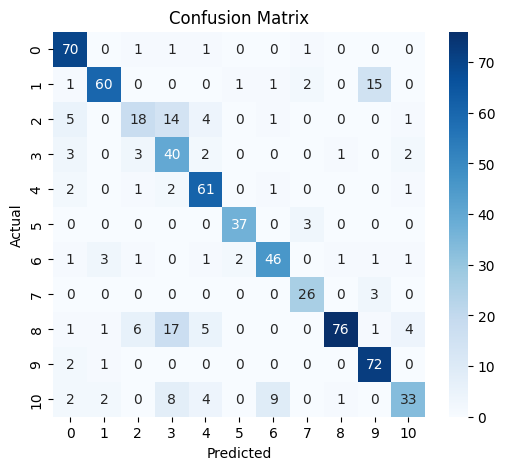

(0.784570596797671,
 array([[70,  0,  1,  1,  1,  0,  0,  1,  0,  0,  0],
        [ 1, 60,  0,  0,  0,  1,  1,  2,  0, 15,  0],
        [ 5,  0, 18, 14,  4,  0,  1,  0,  0,  0,  1],
        [ 3,  0,  3, 40,  2,  0,  0,  0,  1,  0,  2],
        [ 2,  0,  1,  2, 61,  0,  1,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0, 37,  0,  3,  0,  0,  0],
        [ 1,  3,  1,  0,  1,  2, 46,  0,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 26,  0,  3,  0],
        [ 1,  1,  6, 17,  5,  0,  0,  0, 76,  1,  4],
        [ 2,  1,  0,  0,  0,  0,  0,  0,  0, 72,  0],
        [ 2,  2,  0,  8,  4,  0,  9,  0,  1,  0, 33]]))

In [ ]:
test_metrics(net, test_loader, device, plot_cm=True)

The most important information we can obtain from the classification report and the confusion matrix are:

*   Overall Accuracy: the model achieved 78.46% accuracy
*   Classes 0, 1, 4, 5, 6, 7 and 9 corresponding to Dew, Fog, Hail, Lightning, Rain, Rainbow and Sandstorm have good values for both precision and recall, meaning they are both correctly identified and rarely misclassified.
*   Class 2, corresponding to Frost, has low values for both precision and recall, indicating difficulty in distinguishing this category from others. In particular, as we can see from the confusion matrix, Frost has been frequently classified as Glaze (3), indeed some images from these two classes are similar and they could be difficult to distinguish.
*   Class 3, corresponding to Glaze, has a really low precision, meaning that there are a lot of false positives, ineed some images that are in reality Frost or Rime have been classified as Glaze.




Additionally, I use the model to make predictions on new images that are not part of the dataset, but that I took myself, in order to see the model in action on an example of a "real life" application.

In [ ]:
def predict_and_visualize(image_paths, model, class_names, device):
    """Loads multiple images, runs inference, and displays them with predicted labels"""

    model.eval()
    fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 4))

    for idx, image_path in enumerate(image_paths):
        image = Image.open(image_path).convert("RGB")  # Ensure 3 channels
        image_tensor = test_val_transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted_class = torch.max(output, 1)  # Get the class index

        predicted_label = class_names[predicted_class.item()]  # Get class name

        # Display image with prediction
        ax = axes[idx] if len(image_paths) > 1 else axes  # Handle single image case
        ax.imshow(image)
        ax.set_title(f"Predicted: {predicted_label}")
        ax.axis("off")

    plt.show()

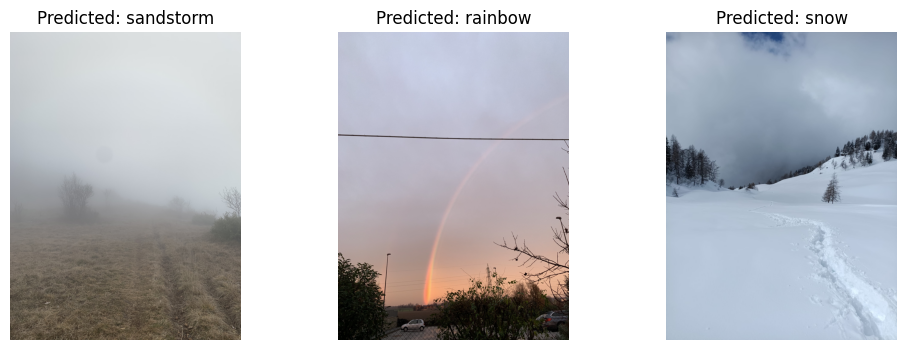

In [ ]:
# Example usage
image_paths = ["/content/drive/MyDrive/Università/Deep Learning for AI/Project/Image1.jpg","/content/drive/MyDrive/Università/Deep Learning for AI/Project/Image2.jpg","/content/drive/MyDrive/Università/Deep Learning for AI/Project/Image4.jpg"]
predict_and_visualize(image_paths, net, class_names, device)

The model correctly predicted images 2 and 3 as rainbow and snow, but failed on image 1, which was classified as sandstorm when it should be fog.
